#**Introduction**
Goal is to predict the patient's head side in the 3D point images. We employ deep learning approach for it. We will be implementing PointNet [(Qi et al., 2017)](https://arxiv.org/abs/1612.00593) for that purpose.



Before you began, make sure your drive structure looks like this.
```
***Drive Structure***
- MyDrive
  - Projects
    - head_location_3d_points
      - Implementation
      - dataset
      - models
      
```
[Folder example link](https://drive.google.com/drive/folders/1mIn7yr21-c91o0agnBoLqqxOB8jnryHD?usp=sharing)

Add the shared `head_location_3d_points` folder to your drive under the `Projects` folder  (make `Projects` folder in your drive if you do not have one).

##Setup

In [1]:
# Mount the drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Change current working directory
import os
os.chdir('/content/gdrive/MyDrive/Projects/head_location_3d_points')

Run the following two blocks just once to install the trimesh library. Next time you can just import it from the drive via sys.path.append

In [3]:
# import sys
# modules_path = '/content/gdrive/MyDrive/Projects/head_location_3d_points/modules'
# sys.path.insert(0, modules_path)

In [4]:
# !pip install --target=$modules_path trimesh

In [5]:
import sys
sys.path.append('/content/gdrive/MyDrive/Projects/head_location_3d_points/modules')

In [6]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(17)

##Reading Data
We can use the [trimesh](https://github.com/mikedh/trimesh) library to read and visualize .obj mesh files.

In [ ]:
TRAIN_DIR = './dataset/train'

In [ ]:
DATA_DIR = './dataset'
mesh = trimesh.load(os.path.join(DATA_DIR, 'train/head_right/head_right_1.obj'))
mesh.show()

To convert a mesh file to a point cloud we first need to sample points on the mesh surface. .sample() performs a unifrom random sampling. Here we sample at 2048 locations and visualize in matplotlib.

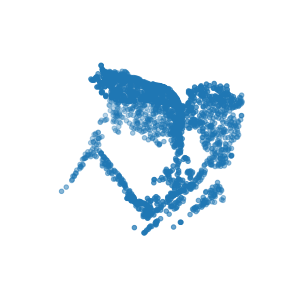

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

##Preparing Data

To generate a tf.data.Dataset() we need to first parse through the ModelNet data folders. Each mesh is loaded and sampled into a point cloud before being added to a standard python list and converted to a numpy array. We also store the current enumerate index value as the object label and use a dictionary to recall this later.

In [ ]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = os.listdir(os.path.join(DATA_DIR, "train"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(DATA_DIR, "train", folder, "*"))
        test_files = glob.glob(os.path.join(DATA_DIR, "test", folder, "*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

Set the number of points to sample and batch size and parse the dataset. This can take some time to complete.

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 2
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: head_right
processing class: head_left


In [ ]:
print(train_points[0].shape)

(2048, 3)


Our input data is 2048 points, each with X, Y, Z coordinates. Therefore our input shape is 2048 by 3.

In [ ]:
print(len(train_points))
print(len(train_labels))
print(len(test_points))
print(len(test_points))

186
186
10
10


Our data can now be read into a tf.data.Dataset() object. We set the shuffle buffer size to the entire size of the dataset as prior to this the data is ordered by class. Data augmentation is important when working with point cloud data to overcome overfitting. We create a augmentation function to jitter and shuffle the train dataset.



We use two types of augmentation i.e. jitter and shuffle. 

Jitter is interesting and natural data augmentation where we just add random noise to points position in X, Y, Z space.

We can also randomly shuffle how data points are presented sequentially w.r.t this data type of 2048 (X, Y, Z) pair. We shuffle so that the model is not biased towards particular ordering after the sample function.

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

# Convert data types to tf.data object
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

##Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components. The primary MLP network, and the transformer net (T-net). The T-net aims to learn an affine transformation matrix by its own mini network. The T-net is used twice. The first time to transform the input features (n, 3) into a canonical representation. The second is an affine transformation for alignment in feature space (n, 3). As per the [original paper](https://arxiv.org/abs/1612.00593) we constrain the transformation to be close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0). It is just kind of like feature transformation.

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features) # Identity matrix

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

We can then define a general function to build T-net layers.

The main idea behind the Tnet blocks is to take the input space of 2048 point clouds and project it into matrix that we can use for a more standard deep neural network pipeline. We calculate transformation matrix and then apply it to inputs.

After projection we can just apply standard things like convolution and activations in normal fashion. If you are more curious about the exact intuition behind the PointNet architecture, I recommend you to read the original paper. I myself don't understand all the linear algebra behind this transformation.



In [ ]:
def tnet(inputs, num_features):

    # Initialize bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

The main network can be then implemented in the same manner where the t-net mini models can be dropped in a layers in the graph. Here we replicate the network architecture published in the original paper but with half the number of weights at each layer as we are using a smaller dataset.

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256) 
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

##Train model

Once the model is defined it can be trained like any other standard classification model using .compile() and .fit().

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('./models/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [ ]:
 model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=checkpoint)

Epoch 1/20
6/6 [==============================] - 9s 334ms/step - loss: 2.8420 - sparse_categorical_accuracy: 0.6022 - val_loss: 4.0840 - val_sparse_categorical_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 4.08403, saving model to ./models/best_model.h5
Epoch 2/20
6/6 [==============================] - 1s 150ms/step - loss: 2.5901 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.8977 - val_sparse_categorical_accuracy: 0.8000

Epoch 00002: val_loss improved from 4.08403 to 0.89767, saving model to ./models/best_model.h5
Epoch 3/20
6/6 [==============================] - 1s 151ms/step - loss: 1.9299 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.9000

Epoch 00003: val_loss improved from 0.89767 to 0.89207, saving model to ./models/best_model.h5
Epoch 4/20
6/6 [==============================] - 1s 148ms/step - loss: 1.6793 - sparse_categorical_accuracy: 0.8226 - val_loss: 2.0038 - val_sparse_categorical_accuracy: 0.7000

Epo

##Visualize predicitons

We can use matplotlib to visualize our trained model performance.



If you already have a saved mode, run the program up to model.compile() and do not run model.fit().

Instead load the saved model with the following block.

In [ ]:
model.load_weights('./models/best_model.h5')

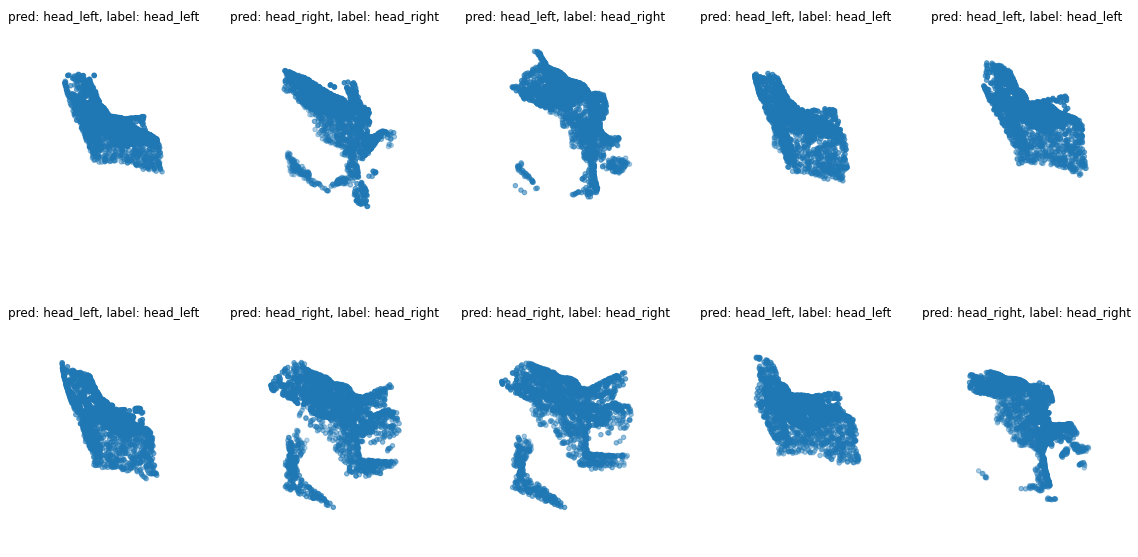

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:len(test_points), ...]
labels = labels[:len(test_points), ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(20, 10))
for i in range(len(test_points)):
    ax = fig.add_subplot(2, 5, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
# Accuracy calculation

correct = 0
for i in range (len(test_points)):
  if (preds[i] == labels[i]):
    correct += 1 

accuracy = 100 * correct / len(test_points)
print(f"Accuracy is: {accuracy}")

Accuracy is: 90.0


## Predicting on new data

In [ ]:
# TEST_DIR = './dataset/test_prediction/'
# for i, folder in enumerate(TEST_DIR):
#   path = os.path.join(TEST_DIR, folder)
#   for obj in os.listdir(path):
#     mesh_path = os.path.join(path, obj)
#     mesh = trimesh.load(mesh_path)
#     points = mesh.sample(2048)
#     print(points.shape)
#     points = points[None]
#     print(points.shape)
#     break
#   break

In [ ]:
import re

TEST_DIR = './dataset/test_prediction/'
classes = os.listdir(os.path.join(DATA_DIR, "test"))

objects = os.listdir(TEST_DIR)
for obj in objects:
  split = re.split("_", obj)
  label = split[0] + '_' + split[1]

  mesh_path = os.path.join(TEST_DIR, obj)
  mesh = trimesh.load(mesh_path)
  points = mesh.sample(2048)
  points = points[None] # To change the shape (adding dimension for batch)

  # run test data through model
  pred = model.predict(points)
  pred = tf.math.argmax(pred, -1)
  pred = int(pred)

  predicted_class = classes[pred]

  fig = plt.figure(figsize=(5, 4))
  ax = plt.axes(projection='3d')
  ax.scatter(points[:, :, 0], points[:, :, 1], points[:, :, 2])
  plt.title(f'Prediction: {predicted_class}, Actual: {label}')
  plt.show()

##Some visualization testing

You can ignore this part.


In [ ]:
import plotly.graph_objects as go

DATA_DIR = './dataset'
mesh = trimesh.load(os.path.join(DATA_DIR, 'train/head_right/head_right_1.obj'))
mesh.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
points = mesh.sample(2048)

In [ ]:
fig = go.Figure(data=[go.Mesh3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], alphahull=5, color='cyan', opacity=0.50)])
fig.show()